# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
#Посмотрим вообще на таблицу
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


Для определения числа объектов ориентироваться стоит на дату размещения - она-то точно должна быть у каждого объекта. Видимо, всего 23699 объектов (но на всякий случай проверим). Тогда пропуски есть в: ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition.

Логично заменить на 0 отсутствующие значения в balcony, parks_around3000, ponds_around3000. Возможно, ещё days_exposition - если объявление сняли в тот же день. В остальных случаях корректно оставить пропуск: вероятнее всего, данные просто не указаны пользователями.

Проверим, правда ли всего строчек 23699

In [6]:
len(data[data['total_images'].isna()])

0

Итак, действительно, речь идёт о 23699 объявлениях. Имеет смысл заменить тип данных в days_exposition (потому что зачем нам доли дней размещения?), floors_total, balcony и всё, что касается расстояния - на int, а is_apartment - на булев тип.

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

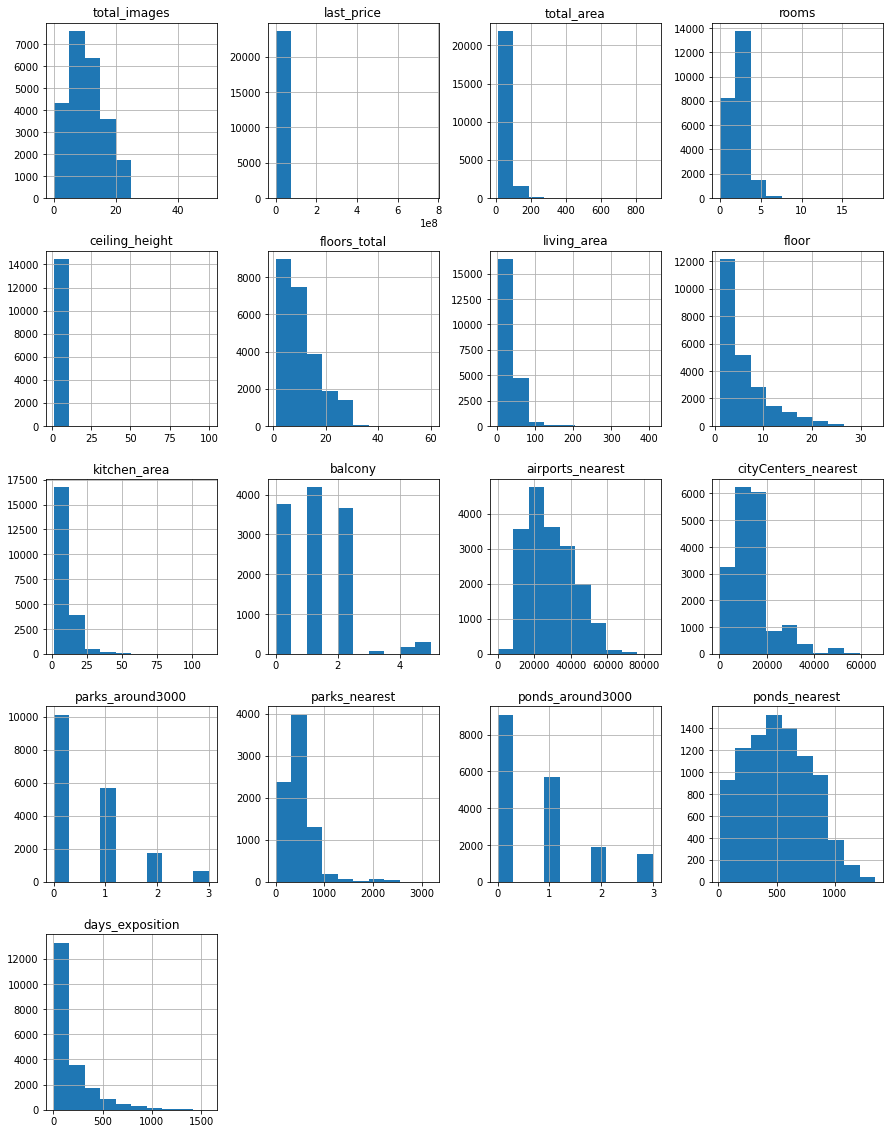

In [7]:
data.hist(figsize=(15, 20))

### Предобработка данных

In [9]:
#Можно искать аномалии на этом этапе, но проще будет смотреть на гистограммы в исследовательском анализе.
#Заменим пропуски на 0
data['balcony']=data['balcony'].fillna(0)
data['balcony']=data['balcony'].fillna(0)
data['parks_around3000']=data['parks_around3000'].fillna(0)
data['ponds_around3000']=data['ponds_around3000'].fillna(0)
data['days_exposition']=data['days_exposition'].fillna(0)

In [10]:
#Поменяем тип данных на int:  число балконов, этажей и парков с водоёмами вокруг исчисляется натуральными числами,
#а доли метров до парков и водоёмов, как и дней, нам неважны.
data['days_exposition'] = data['days_exposition'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT')
    
data['airports_nearest'] = data['airports_nearest'].astype('Int64')
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('Int64')
data['parks_nearest'] = data['parks_nearest'].astype('Int64')
data['ponds_nearest'] = data['ponds_nearest'].astype('Int64')

data['is_apartment'].unique() 
#Вероятнее всего, если владелец пропустил пункт про апартаменты, то это не они.
data['is_apartment']=data['is_apartment'].fillna(False)
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,25.00,0,Санкт-Петербург,18863,16028,1,482,2,755,0
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.6,1,False,...,11.00,2,посёлок Шушары,12817,18603,0,<NA>,0,<NA>,81
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.3,4,False,...,8.30,0,Санкт-Петербург,21741,13933,1,90,2,574,558
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,NaN,9,False,...,NaN,0,Санкт-Петербург,28098,6800,2,84,3,234,424
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,41.00,0,Санкт-Петербург,31856,8098,2,112,1,48,121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,13.83,0,Санкт-Петербург,24665,4232,1,796,3,381,0
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5.0,38.0,4,False,...,8.50,0,Тосно,<NA>,<NA>,0,<NA>,0,<NA>,45
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,False,...,NaN,0,село Рождествено,<NA>,<NA>,0,<NA>,0,<NA>,0
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,NaN,12,False,...,23.30,2,Санкт-Петербург,39140,10364,2,173,3,196,602


In [11]:
#Проверим на дубликаты
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [12]:
data['locality_name']=data['locality_name'].replace('поселок Мурино', 'посёлок Мурино')
data['locality_name']=data['locality_name'].replace('Мурино', 'посёлок Мурино')
data['locality_name']=data['locality_name'].replace('городской поселок Янино-1', 'городской посёлок Янино-1')
data['locality_name']=data['locality_name'].replace('деревня Кудрово', 'Кудрово')
#Гугл говорит, с 2018 года деревня стала городом
data['locality_name']=data['locality_name'].replace('поселок Аннино', 'посёлок Аннино')
data['locality_name']=data['locality_name'].replace('поселок Бугры', 'посёлок Бугры')
data['locality_name']=data['locality_name'].replace('поселок Возрождение', 'посёлок Возрождение')
data['locality_name']=data['locality_name'].replace('поселок Гаврилово', 'посёлок Гаврилово')
data['locality_name']=data['locality_name'].replace('поселок Ильичёво', 'посёлок Ильичёво')
data['locality_name']=data['locality_name'].replace('поселок Кобралово', 'посёлок Кобралово')
data['locality_name']=data['locality_name'].replace('поселок Коробицыно', 'посёлок Коробицыно')
data['locality_name']=data['locality_name'].replace('поселок Лисий Нос', 'посёлок Лисий Нос')
data['locality_name']=data['locality_name'].replace('поселок Мельниково', 'посёлок Мельниково')
data['locality_name']=data['locality_name'].replace('поселок Мичуринское', 'посёлок Мичуринское')
data['locality_name']=data['locality_name'].replace('поселок Новый Свет', 'посёлок Новый Свет')
data['locality_name']=data['locality_name'].replace('поселок Пансионат Зелёный Бор', 'посёлок Пансионат Зелёный Бор')
data['locality_name']=data['locality_name'].replace('поселок Перово', 'посёлок Перово')
data['locality_name']=data['locality_name'].replace('поселок Петровское', 'посёлок Петровское')
data['locality_name']=data['locality_name'].replace('поселок Победа', 'посёлок Победа')
data['locality_name']=data['locality_name'].replace('поселок Поляны', 'посёлок Поляны')
data['locality_name']=data['locality_name'].replace('поселок Старая Малукса', 'посёлок Старая Малукса')
data['locality_name']=data['locality_name'].replace('поселок Стеклянный', 'посёлок Стеклянный')
data['locality_name']=data['locality_name'].replace('поселок Сумино', 'посёлок Сумино')
data['locality_name']=data['locality_name'].replace('поселок Тельмана', 'посёлок Тельмана')
data['locality_name']=data['locality_name'].replace('поселок Терволово', 'посёлок Терволово')
data['locality_name']=data['locality_name'].replace('поселок Усть-Луга', 'посёлок Усть-Луга')
data['locality_name']=data['locality_name'].replace('городской посёлок Мга', 'посёлок городского типа Мга')
data['locality_name']=data['locality_name'].replace('городской поселок Павлово', 'посёлок городского типа Павлово')
data['locality_name']=data['locality_name'].replace('городской поселок Рощино', 'посёлок городского типа Рощино')
data['locality_name']=data['locality_name'].replace('поселок станции Вещево', 'посёлок при железнодорожной станции Вещево')
data['locality_name']=data['locality_name'].replace('поселок станции Приветнинское', 'посёлок при железнодорожной станции Приветнинское')
data['locality_name']=data['locality_name'].replace('Никольское', 'село Никольское')

data['locality_name'].unique()



array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Слан

Неявные дубликаты (дублирование локаций из-за написания "поселок" и "посёлок", "городской посёлок" и "посёлок городского типа", "посёлок станции" и "посёлок при железнодорожной станции", а также из-за неуказывания в некоторых случаях типа локации: "Мурино" и "посёлок Мурино") устранены.

### Посчитайте и добавьте в таблицу новые столбцы

In [13]:
#Добавим в таблицу полезные данные: цену за кв.метр, этаж (первый/последний/другой), день публикации и отношения площадей

try:
    data['price_per_area']=round(data['last_price']/data['total_area'], 0)
except:
    display('Недостаточно данных!')
    
try:
    data['living_per_all_area, %']=round(data['living_area']/data['total_area']*100,0)
except:
    display('Недостаточно данных!')
    
try:
    data['kitchen_per_all_area, %']=round(data['kitchen_area']/data['total_area']*100,0)
except:
    display('Недостаточно данных!')
    
def floor_status(row):
#Функция, сравнивающая этаж, на котором расположена квартира, с числом этажей в доме и с 1 - и делающая вывод о "статусе" этажа
    floor_number= row['floors_total']
    flat_floor = row['floor']
    if  floor_number==flat_floor:
        status = 'Последний'
    elif flat_floor==1:
        status = 'Первый'
    else:
        status='Другой'
    return status
data['floor_status']=data.apply(floor_status, axis=1)

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d') #Переведём в формат времени

data['year'] = data['first_day_exposition'].dt.year
data['month'] = data['first_day_exposition'].dt.month
data['day_of_month'] = data['first_day_exposition'].dt.day
data['day_of_week'] = data['first_day_exposition'].dt.day_name()   
# И исходный столбец нам больше не нужен:
data=data.drop('first_day_exposition',1)
data

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,ponds_nearest,days_exposition,price_per_area,"living_per_all_area, %","kitchen_per_all_area, %",floor_status,year,month,day_of_month,day_of_week
0,20,13000000.0,108.00,3,2.70,16.0,51.0,8,False,False,...,755,0,120370.0,47.0,23.0,Другой,2019,3,7,Thursday
1,7,3350000.0,40.40,1,NaN,11.0,18.6,1,False,False,...,<NA>,81,82921.0,46.0,27.0,Первый,2018,12,4,Tuesday
2,10,5196000.0,56.00,2,NaN,5.0,34.3,4,False,False,...,574,558,92786.0,61.0,15.0,Другой,2015,8,20,Thursday
3,0,64900000.0,159.00,3,NaN,14.0,NaN,9,False,False,...,234,424,408176.0,NaN,NaN,Другой,2015,7,24,Friday
4,2,10000000.0,100.00,2,3.03,14.0,32.0,13,False,False,...,48,121,100000.0,32.0,41.0,Другой,2018,6,19,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,3,3.70,5.0,73.3,3,False,False,...,381,0,72491.0,55.0,10.0,Другой,2017,3,21,Tuesday
23695,14,3100000.0,59.00,3,NaN,5.0,38.0,4,False,False,...,<NA>,45,52542.0,64.0,14.0,Другой,2018,1,15,Monday
23696,18,2500000.0,56.70,2,NaN,3.0,29.7,1,False,False,...,<NA>,0,44092.0,52.0,NaN,Первый,2018,2,11,Sunday
23697,13,11475000.0,76.75,2,3.00,17.0,NaN,12,False,False,...,196,602,149511.0,NaN,30.0,Другой,2017,3,28,Tuesday


Теперь в таблице очень много столбцов, но они полезные :) Впрочем, удобнее будет разбить таблицу на несколько

In [14]:
#Создадим таблицу, описывающую зависимость цены от свойств объявления
price_and_advt = data[['last_price', 'price_per_area','total_images', 'year', 'month', 'day_of_month', 'day_of_week','days_exposition']]
price_and_advt

,last_price,price_per_area,total_images,year,month,day_of_month,day_of_week,days_exposition
0,13000000.0,120370.0,20,2019,3,7,Thursday,0
1,3350000.0,82921.0,7,2018,12,4,Tuesday,81
2,5196000.0,92786.0,10,2015,8,20,Thursday,558
3,64900000.0,408176.0,0,2015,7,24,Friday,424
4,10000000.0,100000.0,2,2018,6,19,Tuesday,121
...,...,...,...,...,...,...,...,...
23694,9700000.0,72491.0,9,2017,3,21,Tuesday,0
23695,3100000.0,52542.0,14,2018,1,15,Monday,45
23696,2500000.0,44092.0,18,2018,2,11,Sunday,0
23697,11475000.0,149511.0,13,2017,3,28,Tuesday,602


In [15]:
#Создадим таблицу, описывающую зависимость цены от свойств самой квартиры
price_and_flat = data[['last_price', 'price_per_area','is_apartment','studio','open_plan', 'floor','floor_status','total_area','living_area','kitchen_area','ceiling_height','rooms', 'balcony', 'living_per_all_area, %','kitchen_per_all_area, %']]

price_and_flat

,last_price,price_per_area,is_apartment,studio,open_plan,floor,floor_status,total_area,living_area,kitchen_area,ceiling_height,rooms,balcony,"living_per_all_area, %","kitchen_per_all_area, %"
0,13000000.0,120370.0,False,False,False,8,Другой,108.00,51.0,25.00,2.70,3,0,47.0,23.0
1,3350000.0,82921.0,False,False,False,1,Первый,40.40,18.6,11.00,NaN,1,2,46.0,27.0
2,5196000.0,92786.0,False,False,False,4,Другой,56.00,34.3,8.30,NaN,2,0,61.0,15.0
3,64900000.0,408176.0,False,False,False,9,Другой,159.00,NaN,NaN,NaN,3,0,NaN,NaN
4,10000000.0,100000.0,False,False,False,13,Другой,100.00,32.0,41.00,3.03,2,0,32.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9700000.0,72491.0,False,False,False,3,Другой,133.81,73.3,13.83,3.70,3,0,55.0,10.0
23695,3100000.0,52542.0,False,False,False,4,Другой,59.00,38.0,8.50,NaN,3,0,64.0,14.0
23696,2500000.0,44092.0,False,False,False,1,Первый,56.70,29.7,NaN,NaN,2,0,52.0,NaN
23697,11475000.0,149511.0,False,False,False,12,Другой,76.75,NaN,23.30,3.00,2,2,NaN,30.0


In [16]:
#Создадим таблицу, описывающую зависимость цены от расположения дома
price_and_location =data[['last_price', 'price_per_area','locality_name','airports_nearest','cityCenters_nearest','parks_around3000','parks_nearest','ponds_around3000','ponds_nearest']].copy()
#Переведём расстояние до центра города и до аэропорта в км
price_and_location['cityCenters_nearest_km']=price_and_location['cityCenters_nearest']/1000
price_and_location['cityCenters_nearest_km']=price_and_location['cityCenters_nearest_km'].astype(float).round(1)

price_and_location['airports_nearest_km']=price_and_location['airports_nearest']/1000
price_and_location['airports_nearest_km']=price_and_location['airports_nearest_km'].astype(float).round(1)

#Удалим информацию о расстоянии до аэропорта и центра города в метрах, т.к информация дублируется
price_and_location=price_and_location.drop('cityCenters_nearest',1) 
price_and_location=price_and_location.drop('airports_nearest',1) 
price_and_location

,last_price,price_per_area,locality_name,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,cityCenters_nearest_km,airports_nearest_km
0,13000000.0,120370.0,Санкт-Петербург,1,482,2,755,16.0,18.9
1,3350000.0,82921.0,посёлок Шушары,0,<NA>,0,<NA>,18.6,12.8
2,5196000.0,92786.0,Санкт-Петербург,1,90,2,574,13.9,21.7
3,64900000.0,408176.0,Санкт-Петербург,2,84,3,234,6.8,28.1
4,10000000.0,100000.0,Санкт-Петербург,2,112,1,48,8.1,31.9
...,...,...,...,...,...,...,...,...,...
23694,9700000.0,72491.0,Санкт-Петербург,1,796,3,381,4.2,24.7
23695,3100000.0,52542.0,Тосно,0,<NA>,0,<NA>,NaN,NaN
23696,2500000.0,44092.0,село Рождествено,0,<NA>,0,<NA>,NaN,NaN
23697,11475000.0,149511.0,Санкт-Петербург,2,173,3,196,10.4,39.1


Теперь данные разбиты на удобные таблицы, часть данных переведена в удобный для восприятия вид.

### Выбросим выпадающие значения

#### Полная цена квартиры

Cреди квартир есть резко выбивающиеся по цене. Предположу, что это элитное жильё, и сравнивать его с обычным было бы некорректно. Установлю границу "обычного" жилья - 100 миллионов.

(1.0, 20000000.0)

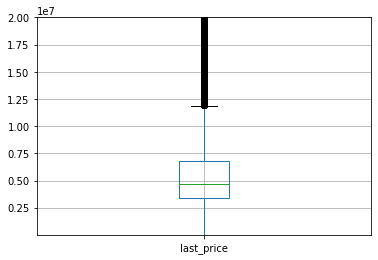

In [17]:
price_and_flat.boxplot(column=['last_price'])
#Подтверждение, что оценка была выбрана правильно
plt.ylim(1,20000000)

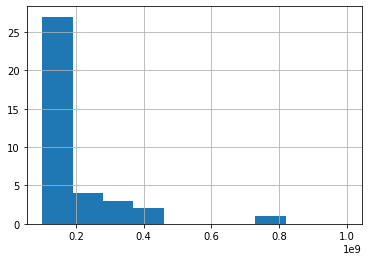

In [18]:
#Оценка количества отброшеннных данных:
price_and_flat['last_price'].hist(bins=10, range=(100000000,1000000000))
#Выбросов менее 0.5%
price_and_flat=price_and_flat.query('last_price<=100000000')

#### Количество комнат

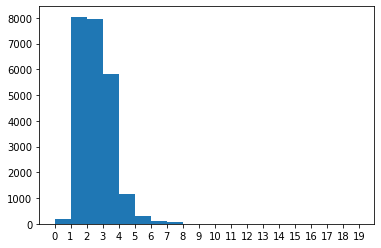

In [19]:
#Исследуем данные, связанные с числом комнат
price_and_flat.sort_values(by='rooms').tail(10)
#19 комнат, божечки...

plt.hist(price_and_flat['rooms'], bins=19)
plt.xticks(range(20))
plt.show()
#Получилось не очень наглядно. Разделим на куски: "Обычные" квартиры и "многокомнатные"  - где комнат больше 5

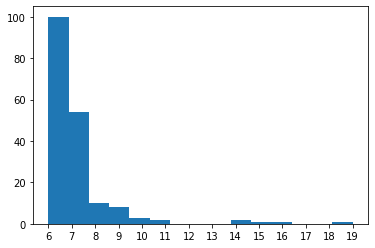

In [20]:
#Кусок, связанный с "многокомнатными" квартирами
plt.hist(price_and_flat['rooms'], bins=15, range=(6,19))
plt.xticks(range(6,20))
plt.show()
#Многокомнатных квартир не очень много, около 1,5% - отбросим эти данные.
price_and_flat=price_and_flat.query('rooms<6')

#### Цена за квадратный метр

<AxesSubplot:>

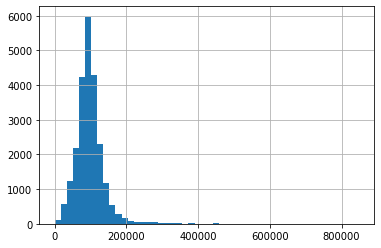

In [21]:
price_and_flat['price_per_area'].hist(bins=50)

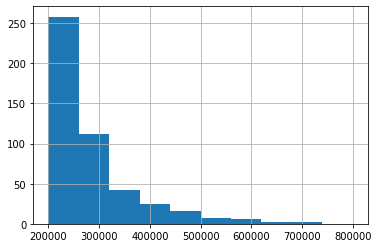

In [22]:
price_and_flat['price_per_area'].hist(bins=10, range=(200000,800000))
#Данных, которые мы считаем выбросами, примерно 1,3%.
price_and_flat=price_and_flat.query('price_per_area<200000')

#### Общая площадь

<AxesSubplot:>

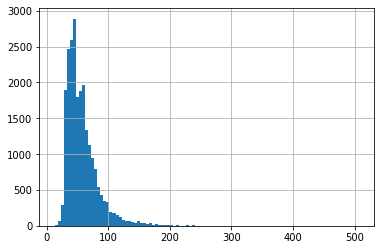

In [23]:
price_and_flat['total_area'].hist(bins=100)

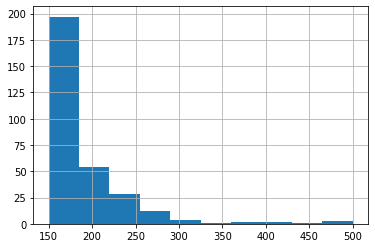

In [24]:
price_and_flat['total_area'].hist(range=(150,500))
#Выбивающихся квартир немного, около 1.5% => устанавливаем границу "обычной" квартиры в 150 м^2
price_and_flat=price_and_flat.query('total_area<150')

#### Высота потолков

<AxesSubplot:>

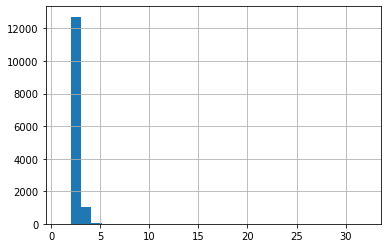

In [25]:
price_and_flat['ceiling_height'].hist(bins=30)

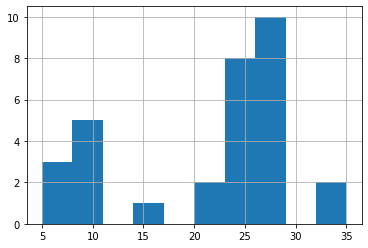

In [26]:
price_and_flat['ceiling_height'].hist(range=(5,35))
#Квартиры с высотой потолков выше 5 метров вряд ли можно считать обычными. Их совсем чуть-чуть, 0.13%  - избавляемся.
price_and_flat=price_and_flat.query('ceiling_height<=5')

#### Число этажей

<AxesSubplot:>

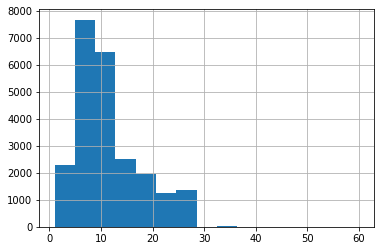

In [27]:
data['floors_total'].hist(bins=15)


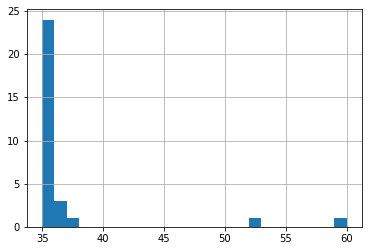

In [28]:
data['floors_total'].hist(range=(35,60), bins=25)
#Гугл говорит, что самое высокое жилое  здание в СПб - ЖК «Князь Александр Невский» - имеет 37 этажей. 
#53 и 59 этажей быть явно не может. Выброшенных данных около 1%. 
data=data.query('floors_total<37')

### Проведите исследовательский анализ данных

#### Исследование полной цены квартиры

<AxesSubplot:>

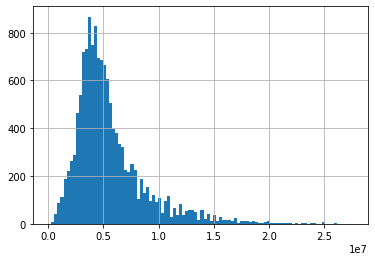

In [29]:
price_and_flat['last_price'].hist(bins=100) 
#Диаграмма не наглядна - большая часть значений лежит в пределах 20 миллионов. Уточним:

count    1.380300e+04
mean     5.560508e+06
std      3.270806e+06
min      1.219000e+04
25%      3.500000e+06
50%      4.700000e+06
75%      6.600000e+06
max      2.757720e+07
Name: last_price, dtype: float64

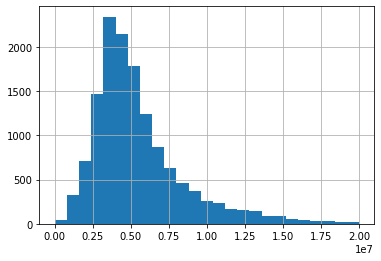

In [30]:
price_and_flat['last_price'].hist(bins=25, range=(0, 20000000))
price_and_flat['last_price'].describe()
#Пик наблюдается при ~3.5 миллионах. Это согласуется с нагугленными данными :)

#### Исследование количества комнат

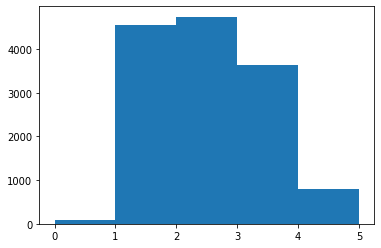

In [31]:
#Кусок, связанный с "обычными" квартирами
plt.hist(price_and_flat['rooms'], bins=5, range=(0,5))
plt.xticks(range(6))
plt.show()
#Больше всего 2-комнатных квартир, чуть меньше 3-комнатных.

In [32]:
price_and_flat['rooms'].describe()

count    13803.000000
mean         2.044193
std          0.940216
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rooms, dtype: float64

#### Исследование цен за квадратный метр

count     13803.000000
mean      96235.243932
std       30909.088338
min         112.000000
25%       77674.500000
50%       95699.000000
75%      114286.000000
max      199597.000000
Name: price_per_area, dtype: float64

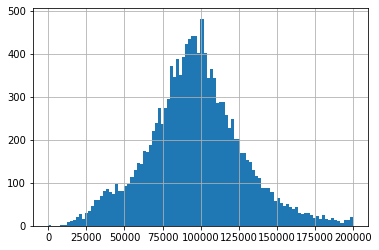

In [33]:
price_and_flat['price_per_area'].hist(bins=100)
#Пик - при 100000 руб/м^2.
price_and_flat['price_per_area'].describe()

#### Исследование общей площади

In [34]:
price_and_flat['total_area'].describe()

count    13803.000000
mean        56.953935
std         22.543863
min         13.000000
25%         40.500000
50%         52.000000
75%         68.100000
max        149.500000
Name: total_area, dtype: float64

<AxesSubplot:>

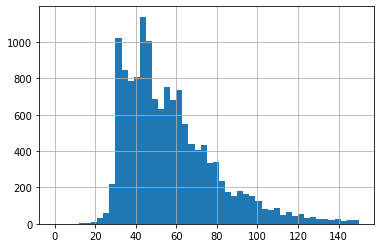

In [35]:
price_and_flat['total_area'].hist(bins=50, range=(0,150))
#Пик - приблизительно на 45 м^2. Пик поменьше - около 60 м^2

#### Исследование жилой площади

count    13065.000000
mean        32.928049
std         15.301741
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        128.000000
Name: living_area, dtype: float64

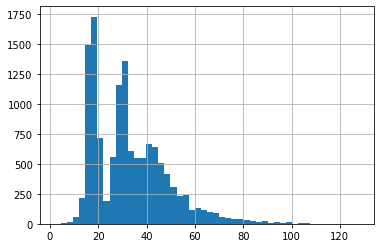

In [36]:
price_and_flat['living_area'].hist(bins=50)
#Наблюдаем два пика: примерно на 18 м^2 и на 30 м^2
price_and_flat['living_area'].describe()

<AxesSubplot:>

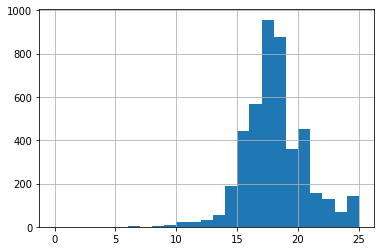

In [37]:
#Разобьём гистограмму на две части, чтобы аккуратнее посмотреть пики.
#Первый пик:
price_and_flat['living_area'].hist(bins=25, range=(0,25))

<AxesSubplot:>

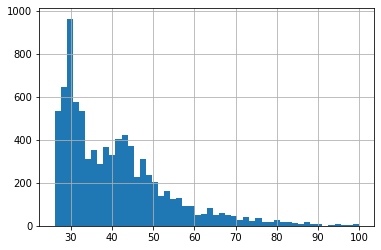

In [38]:
#Второй пик
price_and_flat['living_area'].hist(bins=50, range=(26,100))

// Я даже попала с ~18 и ~30...
Сильно выбивающихся данных нет.  С учётом того, что квартиры общей площадью больше 150 кв.метров мы отбросили, это неудивительно. 
Оценим разброс соотношения жилой площади к общей

<AxesSubplot:>

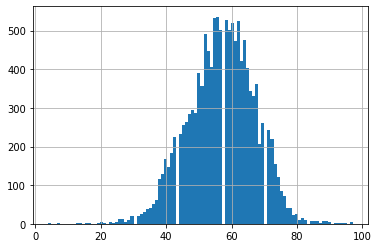

In [39]:
price_and_flat['living_per_all_area, %'].hist(bins=100)
#Распределение выглядит адекватно, хотя два провала на ~50 и на ~75 неожиданны.

<AxesSubplot:>

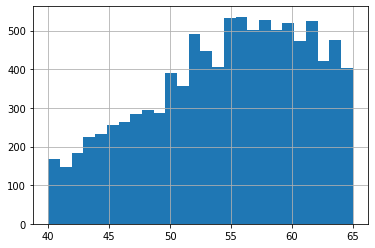

In [40]:
price_and_flat['living_per_all_area, %'].hist(bins=26, range=(40,65))
#price_and_flat['living_per_all_area, %'].hist(bins=20, range=(60,80))
#Интересно, что при более детальном рассмотрении провалы исчезли. С чем это связано понять не смогла :(

#### Исследование площади кухни

count    12933.000000
mean        10.022007
std          4.786335
min          1.300000
25%          7.000000
50%          9.000000
75%         11.400000
max         64.000000
Name: kitchen_area, dtype: float64

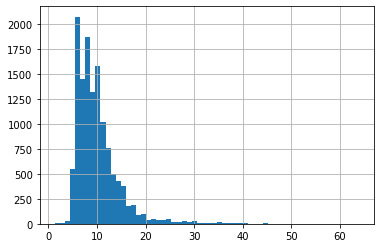

In [41]:
price_and_flat['kitchen_area'].hist(bins=60)
price_and_flat['kitchen_area'].describe()

<AxesSubplot:>

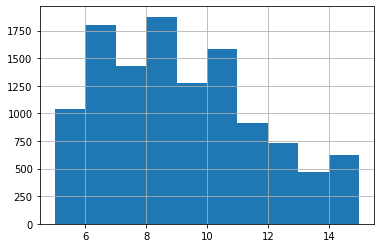

In [42]:
price_and_flat['kitchen_area'].hist(range=(5,15),bins=10)
#Наблюдаем три пика: 7, 9, 11

<AxesSubplot:>

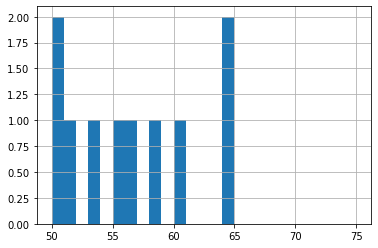

In [43]:
price_and_flat['kitchen_area'].hist(range=(50,75),bins=25)
#Кухни в 65 метров выглядят странно, но их мало. Предположим, такое и правда может быть.

count    12933.000000
mean        18.456893
std          7.061028
min          5.000000
25%         13.000000
50%         17.000000
75%         23.000000
max         72.000000
Name: kitchen_per_all_area, %, dtype: float64

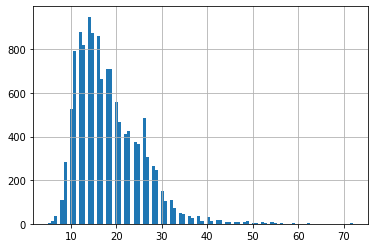

In [44]:
price_and_flat['kitchen_per_all_area, %'].hist(bins=100)
price_and_flat['kitchen_per_all_area, %'].describe()

<AxesSubplot:>

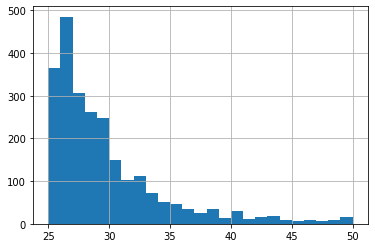

In [45]:
price_and_flat['kitchen_per_all_area, %'].hist(range=(25,50),bins=25)

#### Исследование высоты потолков

count    13803.000000
mean         2.703833
std          0.247616
min          1.000000
25%          2.500000
50%          2.650000
75%          2.790000
max          5.000000
Name: ceiling_height, dtype: float64

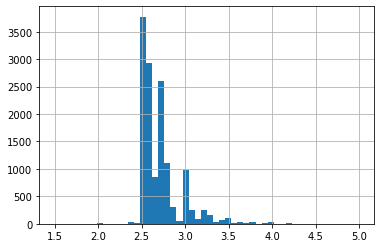

In [46]:
price_and_flat['ceiling_height'].hist(range=(1.5,5), bins=50)
#Пик - на 2,5 метрах
price_and_flat['ceiling_height'].describe()

#### Исследование этажей

<AxesSubplot:>

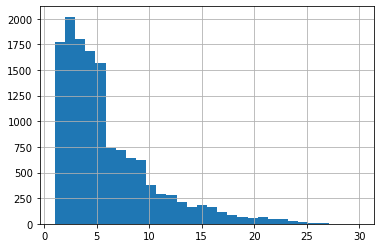

In [47]:
price_and_flat['floor'].hist(bins=30)
#Пик - на втором этаже, выпадающих данных нет

count    13803.000000
mean         5.637180
std          4.635293
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: floor, dtype: float64

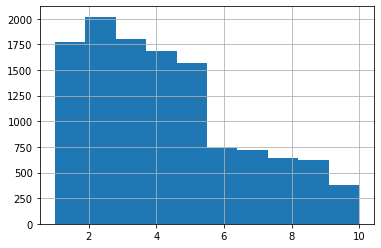

In [48]:
price_and_flat['floor'].hist(range=(1,10),bins=10)
price_and_flat['floor'].describe()

<AxesSubplot:>

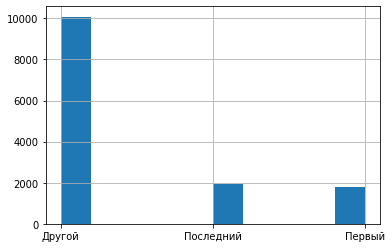

In [49]:
price_and_flat['floor_status'].hist()
#Кажется, похоже на правду. Кваритир не на первом и не на последнем этаже больше приблизительно в 5 раз.

count    23610.000000
mean        10.668869
std          6.582055
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         36.000000
Name: floors_total, dtype: float64

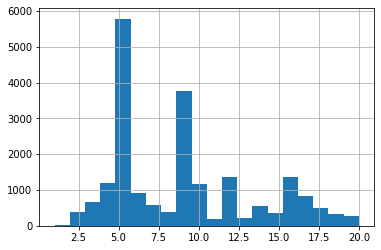

In [50]:
data['floors_total'].hist(range=(1,20), bins=20)
data['floors_total'].describe()
#Больше всего в Питере 5- и 9-этажных зданий

#### Исследование расстояний

count    18180.000000
mean        14.191309
std          8.608045
min          0.200000
25%          9.200000
50%         13.100000
75%         16.300000
max         66.000000
Name: cityCenters_nearest_km, dtype: float64

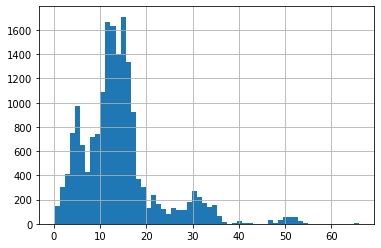

In [51]:
price_and_location['cityCenters_nearest_km'].hist(bins=60)
price_and_location['cityCenters_nearest_km'].describe()
#По заданию нужно было исследовать расстояния в метрах, но, кажется, в километрах оно нагляднее 
#Большая часть квартир находятся на расстоянии 10-15 км от ацентра города.  Это похоже на правду: 
#В радиус 15 км попадает весь СПб и множество маленьких населенных пунктов. Максимальное расстояние около 67 км

count    18157.000000
mean        28.793259
std         12.630643
min          0.000000
25%         18.600000
50%         26.700000
75%         37.300000
max         84.900000
Name: airports_nearest_km, dtype: float64

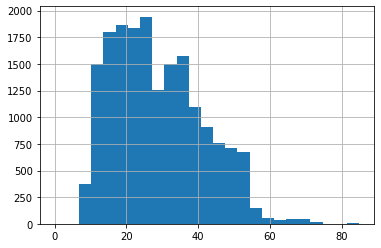

In [52]:
price_and_location['airports_nearest_km'].hist(bins=25)
price_and_location['airports_nearest_km'].describe()
#Больше всего квартир находятся в 10-30 км от аэропорта. 
#Опять-таки, попадает весь СПб и окрестности. Максимальное расстояние  - около 80 км

<AxesSubplot:>

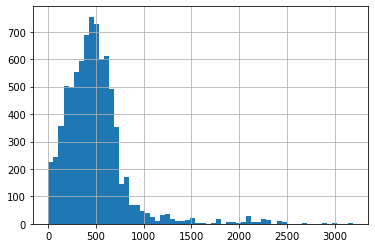

In [53]:
price_and_location['parks_nearest'].hist(bins=60)
#Пик - около 400-500 метров. Максимальное рассстояние - около 3,5 км.

#### Исследование даты публикации объявления

<AxesSubplot:>

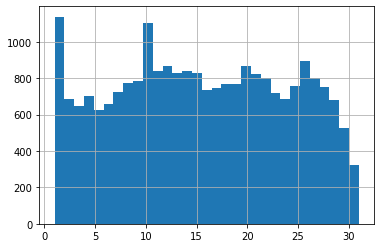

In [54]:
price_and_advt['day_of_month'].hist(bins=31)
#Равномерненько, но 1-ое и 10-ое числа явно выделяется. 1-ое может быть связано с привычкой человека начинать что-то 
#cколь-нибудь глобальное с "красивого" числа. 10-е объяснить сложнее - но тоже может быть связано с "красивым" числом.

<AxesSubplot:>

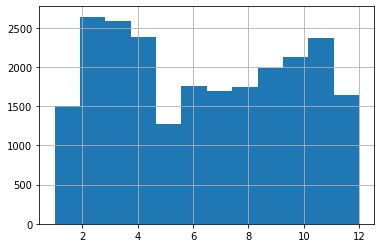

In [55]:
price_and_advt['month'].hist(bins=12)
#Пики - в феврале-апреле и ноябре. В мае меньше всего. Возможно, это связано с сезонами отпусков и праздников.

Итак, мы считаем обычной квартиру с числом комнат <6,  стоимостью меньше 100 миллионов, с ценой за квадратный метр <=200000,  общей площадью менее 150 метров, c высотой потолков меньше 5 м. Также считаем, что этажей в здании не может быть больше 37, т.к это противоречит официальным данным.

### Изучим скорость продажи квартир

<AxesSubplot:>

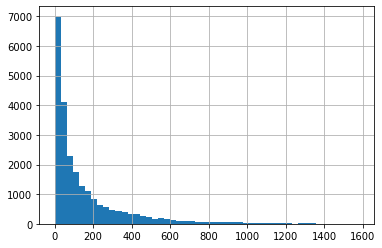

In [56]:
price_and_advt['days_exposition'].hist(bins=50)

In [57]:
price_and_advt['days_exposition'].describe()

count    23699.000000
mean       156.608844
std        213.546873
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

<AxesSubplot:>

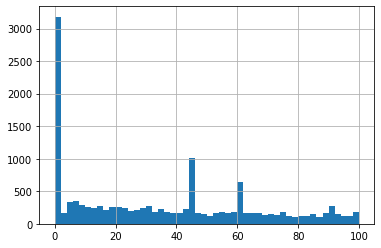

In [58]:
price_and_advt['days_exposition'].hist(range=(0,100),bins=50)
#Очень много квартир продаётся в первый же день. Возможно, часть объявлений пропадает,
#потому что люди находят ошибки в размещённом объявлении и удаляют его для исправления.

Итак, будем считать быстрой продажу, занявшую менее 22 дней (меньше первого квантиля) ; долгой - 200 и более дней. Среднее  время продажи равно 156 дням, медиана - 74 дня.

###  Изучим факторы, влияющие на скорость продажи квартиры

0.7930306245569048

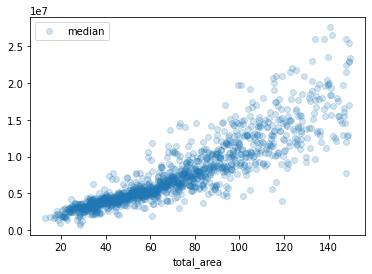

In [59]:
#Зависимость от общей площади 
pivot_table_total_area = price_and_flat.pivot_table(index = 'total_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o',  alpha=0.2)

pivot_table_total_area.sort_values('median', ascending = False)

price_and_flat['total_area'].corr(price_and_flat['last_price'])


#Корреляция сильная - 0,79

0.4919972930924971

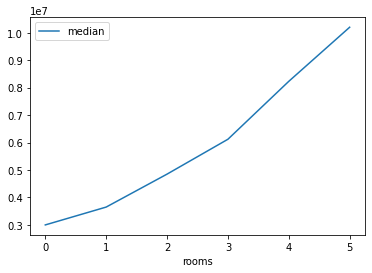

In [60]:
#Зависимость цены от числа комнат 
pivot_table_rooms = price_and_flat.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.plot(y = 'median')

pivot_table_rooms.sort_values('median', ascending = False)

price_and_flat['rooms'].corr(price_and_flat['last_price'])
#Корреляция слабая - 0,49. Зависимость условно можно назвать прямой пропорциональностью - чем больше комнат, тем выше цена квартиры.

0.6663562272940086

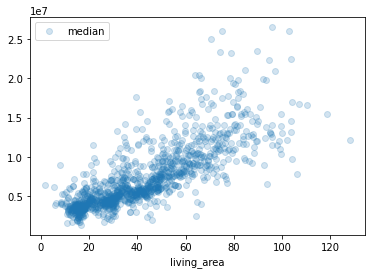

In [61]:
#Зависимость цены от "жилой" площади
pivot_table_living_area = price_and_flat.pivot_table(index = 'living_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_living_area.columns = ['mean', 'count', 'median']
pivot_table_living_area.plot(y = 'median', style = 'o', alpha=0.2)
#hw.plot(x='height', y='weight', kind='scatter') 
pivot_table_living_area.sort_values('median', ascending = False)


price_and_flat['living_area'].corr(price_and_flat['last_price'])
#Корреляция средняя - 0,67. Определенного типа зависимости нет, хотя при росте жилой площади цена всё-таки увеличивается.

0.5819035291360587

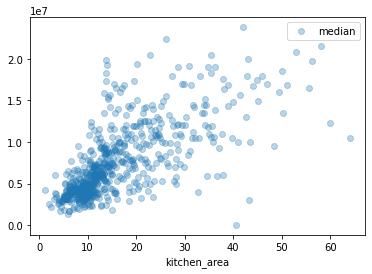

In [62]:
#Зависимость цены от площади кухни
pivot_table_kitchen_area = price_and_flat.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_kitchen_area.columns = ['mean', 'count', 'median']
pivot_table_kitchen_area.plot(y = 'median',style = 'o', alpha=0.3)

pivot_table_rooms.sort_values('median', ascending = False)

price_and_flat['kitchen_area'].corr(price_and_flat['last_price'])
#Корреляция средняя - 0,52. Как и в случае с жилой площадью, определённого типа у зависимости нет, но увеличение всё-таки есть

,mean,count,median
floor_status,,,
Другой,5.802284e+06,10080,4900000.0
Первый,4.529502e+06,1766,4000000.0
Последний,5.245563e+06,1957,4350000.0


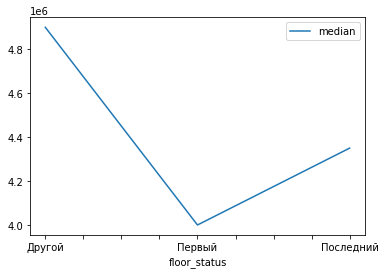

In [63]:
#Зависимость от типа этажа
pivot_table_floor_status = price_and_flat.pivot_table(index = 'floor_status', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_status.columns = ['mean', 'count', 'median']
pivot_table_floor_status.plot(y = 'median')
pivot_table_floor_status

#Ожидаемо, больше всего стоят "другие" этажи. А первые стоят меньше, чем последние - примерно на 9%
#Связано, скорее всего, с тем, что проживание на 1 и последнем этаже влечёт за собой некоторые неудобства, и при прочих равных 
#покупатель, скорее, выберет вариант "другой".

,mean,count,median
day_of_week,,,
Tuesday,6.394233e+06,4183,4730000.0
Wednesday,6.627970e+06,3974,4700000.0
Monday,6.511613e+06,3612,4650000.0
Thursday,6.708663e+06,4295,4650000.0
Friday,6.372131e+06,4000,4585000.0
Saturday,6.976804e+06,1936,4555000.0
Sunday,6.246180e+06,1699,4550000.0


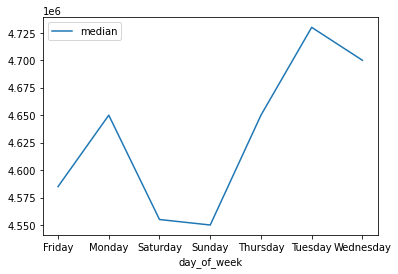

In [64]:
#Зависимость от дня размещения
pivot_table_day = price_and_advt.pivot_table(index = 'day_of_week', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_day.columns = ['mean', 'count', 'median']
pivot_table_day.plot(y = 'median')
pivot_table_day.sort_values('median', ascending = False)

Ниже всего стоимость квартир, выставленных на продажу в выходные. Почему-то мне кажется, что размещение объявления в выходной день означает, что люди занимались этим сами, без риелтора (риелтор разместил бы объявление в свой рабочий день). А риелтор может помочь найти "сильные стороны" квартиры, за которые можно было бы поднять цену. 
Выше всего цена в объявлениях, выставленных во вторник. Возможно, это тоже связано с работой риелторов: в свой выходной люди связываются с риелтором, понедельник используется для сбора информации и подготовки объявления, во вторник объявление выкладывается. 

,mean,count,median
month,,,
4,6.737198e+06,2379,4800000.0
9,6.825470e+06,1981,4700000.0
11,6.461363e+06,2371,4700000.0
12,7.011731e+06,1641,4700000.0
2,6.468500e+06,2640,4650000.0
3,6.359275e+06,2587,4650000.0
7,6.649337e+06,1695,4650000.0
1,6.668233e+06,1500,4600000.0
8,6.350233e+06,1744,4570000.0


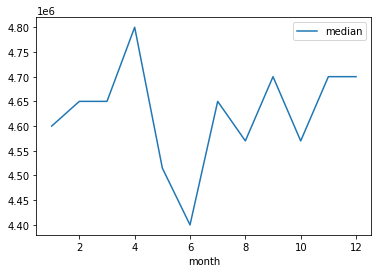

In [65]:
#Зависимость от месяца
pivot_table_day = price_and_advt.pivot_table(index = 'month', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_day.columns = ['mean', 'count', 'median']
pivot_table_day.plot(y = 'median')
pivot_table_day.sort_values('median', ascending = False)

Дороже всего квартиры, выставленные на продажу в апреле. Далее цена резко снижается, и снова растёт только с июля.  Следовательно, на рынке присутствует сезонность - вероятнее всего, это связано с отпусками.

,mean,count,median
year,,,
2014,1.208714e+07,137,7700000.0
2015,8.572833e+06,1191,5350000.0
2019,6.782388e+06,2879,5050000.0
2016,6.827912e+06,2783,4550000.0
2018,5.950966e+06,8519,4550000.0
2017,6.585729e+06,8190,4500000.0


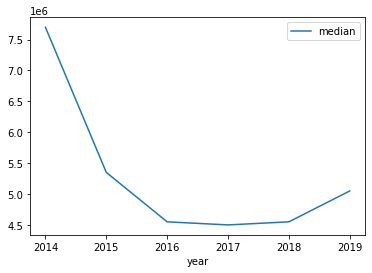

In [66]:
#Зависимость от года
pivot_table_day = price_and_advt.pivot_table(index = 'year', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_day.columns = ['mean', 'count', 'median']
pivot_table_day.plot(y = 'median')
pivot_table_day.sort_values('median', ascending = False)
#Cтоимость квартир снижалась с 2014 по 2016 год. С 2018 года снова начала расти. Возможно, это связано с экономическим кризисом
# и сокращением спроса.

,mean,count,median
year,,,
2014,124830.459854,137,107000.0
2019,107123.773532,2879,103306.0
2018,97773.557460,8519,95690.0
2015,104614.206549,1191,93415.0
2017,97621.874847,8190,92565.0
2016,98322.341358,2783,91743.0


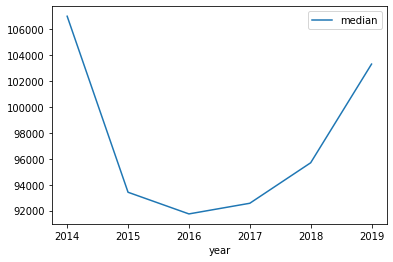

In [67]:
#Зависимость cтоимости квадратного метра от года
pivot_table_day = price_and_advt.pivot_table(index = 'year', values = 'price_per_area', aggfunc = ['mean', 'count', 'median'])
pivot_table_day.columns = ['mean', 'count', 'median']
pivot_table_day.plot(y = 'median')
pivot_table_day.sort_values('median', ascending = False)
#Cтоимость квадратного метра резко упала  с 2014 по 2015 год. В 2016-ом ещё немного снизилась. 
#С 2016 по 2017 год цены начали плавно расти, затем с каждым город скорость роста цен увеличивалась.

#### Вывод
Итак, сильнее всего цена квартиры зависит от её площади (корреляция = 0,79). Чуть меньше - от жилой площади (корреляция = 0,67) и от площади кухни (корреляция = 0,52). Слабо зависит от числа комнат (корреляция = 0,49). 
Больше всего цена в объявлениях, размещённых во вторник, меньше всего - в выходные. Возможно, это косвенно связано с графиком работы риелторов (размещение объявления в выходные может свидетельствовать о продаже кваритиры собственными силами). Также цена в объявлениях падает с мая по июль - возможно, это связано с периодом отпусков. Наконец,  стоимость квартир снижалась с 2014 по 2016 год, и в 2017 году начала увеличиваться. Вероятно, это связано с экономическим кризисом и, соответственно, падением спроса.

### Посчитаем цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [68]:
locality_pivot_table = price_and_location.pivot_table(index = 'locality_name', values = 'price_per_area', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table


,count,mean
locality_name,,
Санкт-Петербург,15721,114849.005788
посёлок Мурино,590,86087.508475
Кудрово,472,95324.957627
посёлок Шушары,440,78677.379545
Всеволожск,398,68654.474874
Пушкин,369,103125.818428
Колпино,338,75424.571006
посёлок Парголово,327,90175.886850
Гатчина,307,68746.110749


<AxesSubplot:xlabel='locality_name'>

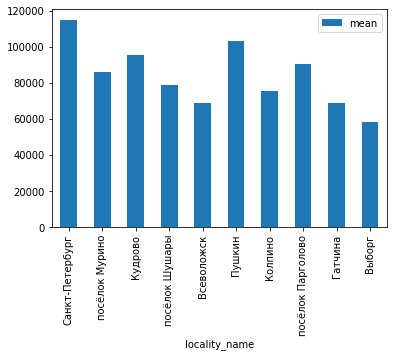

In [69]:
#Столбчатая диаграмма cредней цены в городах
locality_pivot_table.plot(y='mean', kind='bar')

In [70]:
#Самая высокая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]

,count,mean
locality_name,,
Санкт-Петербург,15721,114849.005788


In [71]:
#Cамая низкая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
Выборг,237,58141.919831


#### Вывод:
10 населённых пунктов с наибольшим числом объявлений: Санкт-Петербург, посёлок Мурино, Кудрово, посёлок Шушары, Всеволжск, Пушкин, Колпино, посёлок Парголово, Гатчина, Выборг. Ожидаемо, число объявлений в Петербурге на полтора-два порядка больше, чем в остальных объявлениях. 
Самая большая стоимость жилья, опять же, в Петербурге; самая низкая - в Выборге.

### Найдём цену каждого километра в СПб

,last_price
cityCenters_nearest_km,
0,2.402579e+07
1,1.897459e+07
2,1.631810e+07
3,1.189902e+07
4,1.411770e+07
5,1.519757e+07
6,1.517667e+07
7,1.300653e+07
8,8.616643e+06


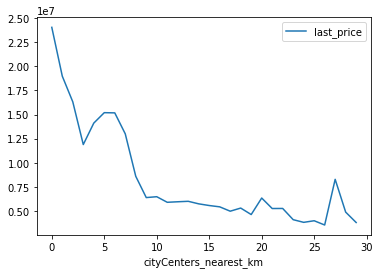

In [72]:
price_and_location['cityCenters_nearest_km'] = price_and_location['cityCenters_nearest_km'].fillna(999999)
price_and_location['cityCenters_nearest_km'] = price_and_location['cityCenters_nearest_km'].astype('int')
pivot_table_km = price_and_location.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km !=999999').pivot_table(index = 'cityCenters_nearest_km', values = 'last_price', aggfunc = 'mean')
pivot_table_km.plot()
pivot_table_km

В среднем, чем ближе к центру города, тем цена за квадратный метр больше. Интересно, что между 3 и 5 км цена снова растёт - возможно, это связано с близостью к Неве?...
Также есть пик на 27 км. Возможно, там находится более крупный населённый пункт.

### Общий вывод

Был изучен и обработан массив данных -  архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.
Некоторые из данных изменены для более удобного восприятия (часть данных округлена, километры переведены в метры,  и т.д), были устранены дубликаты и заполнены пропущенные значения, где это возможно. 

Также были установлены "нормы" для квартиры, считающейся обычной: 
* число комнат <6,  
* стоимость меньше 100 миллионов, 
* цена за квадратный метр <=200000,  
* общая площадь менее 150 метров, 
* высота потолков меньше 5 м. 
* Также считаем, что этажей в здании не может быть больше 37.

Квартиры, не подходящие по критериям, не рассматривались

Мы считаем быстрой продажу, занявшую менее 22 дней (меньше первого квантиля) ; долгой - 200 и более дней. 
* Среднее  время продажи равно 156 дням, медиана - 74 дня

Было установлено, что
* сильнее всего цена квартиры зависит от её площади (корреляция = 0,79). 
* от жилой площади (корреляция = 0,67) и от площади кухни (корреляция = 0,52) цена квартиры зависит слабее
* Слабо зависит от числа комнат (корреляция = 0,49). 


Больше всего цена в объявлениях, размещённых во вторник, меньше всего - в выходные. Возможно, это косвенно связано с графиком работы риелторов (размещение объявления в выходные может свидетельствовать о продаже кваритиры собственными силами). Также цена в объявлениях падает с мая по июль - возможно, это связано с периодом отпусков. Наконец,  стоимость квартир снижалась с 2014 по 2016 год, и в 2017 году начала увеличиваться. Цены за квадратный метр вели себя схоже: стоимость квадратного метра резко упала  с 2014 по 2015 год. В 2016-ом ещё немного снизилась, с 2016 по 2017 год цены начали плавно расти, затем с каждым город скорость роста цен увеличивалась. Вероятно, это связано с экономическим кризисом и, соответственно, падением спроса.

Также было установлено, что из 10 населенных пунктов с наибольшим числом объявлений в Петербурге стоимость квадратного метра самая высокая, а в Выборге - самая низкая. Кроме того, близость к центру города увеличивает стоимость квартиры (что ожидаемо), но на расстоянии 5 км и 27 км наблюдаются пики.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод